# UPF 
## Quick Start
This notebook aims at showing how to use the UPF, NLS[[1]](#1), QCQP[[2]](#2) and ALgebraic[[3]](#3)  soluiton to solve the relative pose estimation problem in 3D (4-dof).  

The note is divided into the following sections:
1. Create drone simulation  
2. The UPF
3. NLS
4. QCQP
5. Algebraic
6. Running analysis
7. Running in ROS environment

### References
<a id="1">[1]</a> 
T. Ziegler, M. Karrer, P. Schmuck, and M. Chli, “Distributed formation
estimation via pairwise distance measurements,” IEEE Robotics and
Automation Letters, vol. 6, no. 2, pp. 3017–3024, 2021

<a id="2">[2]</a> 
T. H. Nguyen and L. Xie, “Relative transformation estimation based
on fusion of odometry and uwb ranging data,” IEEE Transactions on
Robotics, pp. 1–17, 2023.

<a id="3">[3]</a> 
N. Trawny, X. S. Zhou, K. Zhou, and S. I. Roumeliotis, “Interrobot
transformations in 3-d,” IEEE Transactions on Robotics, vol. 26, no. 2,
pp. 226–243, 2010.

### Create drone simulation 


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from Code.Simulation.BiRobotMovement import drone_flight, run_simulation, random_movements_host_random_movements_connected
from Code.UtilityCode.utility_fuctions import sphericalToCartesian

#set parameters
simulation_time = 300
odom_frequency = 10.
odom_time_step = 1/odom_frequency
uwb_frequency = 10.
factor = odom_frequency/uwb_frequency
simulation_time_steps = int(simulation_time / odom_time_step) 

max_range = 10
sigma_v =  0.01
sigma_w = 0.01
sigma_uwb = 0.1


# Created randomised starting positions.
x_drone_0 = sphericalToCartesian(np.array([np.random.uniform(0,max_range), np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi)]))
pose_drone_0 = np.concatenate((x_drone_0, np.array([np.random.uniform(0, 2*np.pi)])))
x_drone_1 = sphericalToCartesian(np.array([np.random.uniform(0,max_range), np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi)]))
pose_drone_1 = np.concatenate((x_drone_1, np.array([np.random.uniform(0, 2*np.pi)])))
# print(pose_drone_0, pose_drone_1)

drone_0 = drone_flight(pose_drone_0, sigma_dv=sigma_v, sigma_dw=sigma_w, max_range=max_range,
                          origin_bool=True, simulation_time_step=odom_time_step)
drone_1 = drone_flight(pose_drone_1, sigma_dv=sigma_v, sigma_dw=sigma_w, max_range=max_range,
                         origin_bool=True, simulation_time_step=odom_time_step)

run_simulation(simulation_time_steps, drone_0, drone_1,
                       random_movements_host_random_movements_connected)

distances = np.linalg.norm(drone_0.x_real - drone_1.x_real, axis=1) + np.random.randn(simulation_time_steps+1) * sigma_uwb
startMeasurement = distances[0] 

{'i': 22665}


### Plotting the simulated trajectory

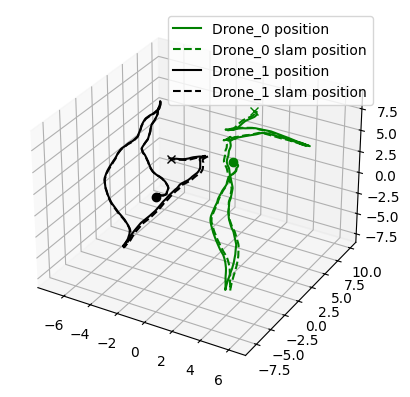

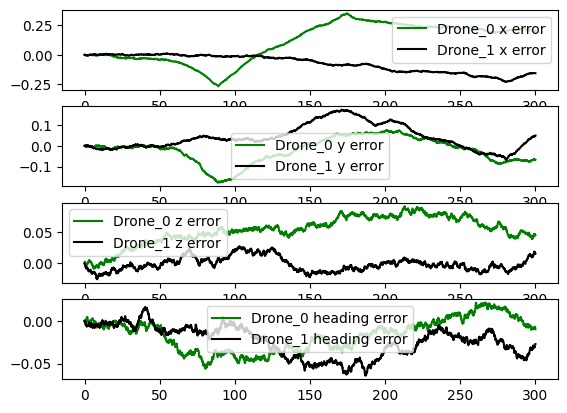

In [22]:
ax = plt.figure().add_subplot(projection='3d')
drone_0.plot_trajectory(ax =ax, color = "green", label="Drone_0 position")
drone_0.plot_slam_position(ax =ax, color = "green", linestyle="--", annotation="Drone_0")
drone_1.plot_trajectory(ax =ax, color = "black", label="Drone_1 position")
drone_1.plot_slam_position(ax =ax, color = "black", linestyle="--", annotation="Drone_1")
ax.legend()

ax = drone_0.plot_slam_error(annotation="Drone_0", color ="green")
ax = drone_1.plot_slam_error(annotation="Drone_1", ax=ax, color="black")
for ax_i in ax: 
    ax_i.legend()


#TODO: add legends
plt.show()

### The UPF
#### Setting up the UPF

In [23]:
from importlib import reload
import Code.DataLoggers.ConnectedAgent_DataLogger as CADL
reload(CADL)

from Code.ParticleFilter.ConnectedAgentClass import UPFConnectedAgent
from Code.DataLoggers.ConnectedAgent_DataLogger import UPFConnectedAgentDataLogger

upf0 = UPFConnectedAgent(id="drone_1", x_ha_0=pose_drone_0, drift_correction_bool=True, resample_factor=0.1)
upf0.set_ukf_parameters(kappa=-1, alpha=1, beta=2)
upf0.split_sphere_in_equal_areas(r=distances[0], sigma_uwb= sigma_uwb, n_azimuth=4, n_altitude=3, n_heading=4)

dl0 = UPFConnectedAgentDataLogger(drone_0, drone_1, upf0)

#### Running the UPF simulation

In [24]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps+1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    d_dx_0 = np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    upf0.ha.predict(d_dx_0, drone_0.q)
    q_0 = q_0 + get_4d_rot_matrix(drone_0.h_slam[i]) @ drone_0.q @ get_4d_rot_matrix(drone_0.h_slam[i]).T
    
    d_dx_1 = np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    f = get_4d_rot_matrix(d_dx_1[-1])
    dx_1 = dx_1 + f @ d_dx_1
    q_1 = q_1 + f @ drone_1.q @ f.T
    if i % factor == 0:
        x_ha = drone_0.x_slam[i]
        h_ha = drone_0.h_slam[i]
        x_ha = np.concatenate([x_ha, np.array([h_ha])])
        
        upf0.ha.update(x_ha, q_0)
        upf0.run_model(dx_1, distances[i], q_ca=q_1)
        dl0.log_data(i)
        
        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        q_0 = np.zeros((4, 4))
        upf0.ha.reset_integration()


### Plotting the results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


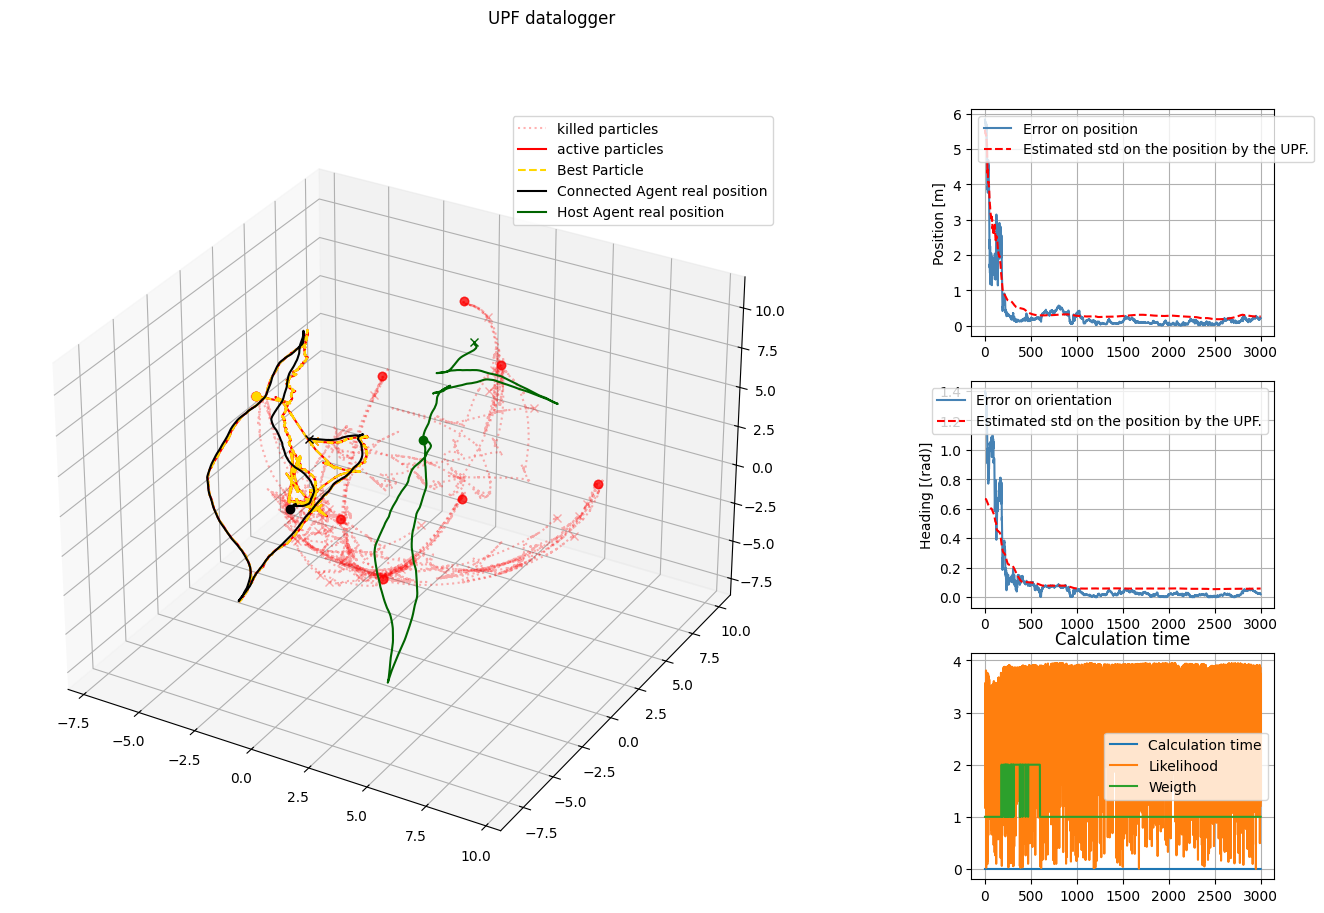

In [25]:
dl0.plot_graph()

### NLS 
#### Setting up the NLS

In [26]:
from importlib import reload
import Code.DataLoggers.NLS_DataLogger as NLSDL
reload(NLSDL)

from Code.BaseLines.NLS import NLS
from Code.DataLoggers.NLS_DataLogger import NLSDataLogger

agents = {"drone_0": drone_0, "drone_1": drone_1}
NLS = NLS(agents, horizon = 10, sigma_uwb=sigma_uwb)
sampling_factor = 10
nls_logger = NLSDataLogger(NLS)
NLS.init_logging(nls_logger)

#### Running the NLS simulation

In [27]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor*sampling_factor) == 0:
        dx = np.vstack([dx_0.reshape(1, *dx_0.shape), dx_1.reshape(1, *dx_1.shape)])
        q_odom = np.vstack([q_0.reshape(1, *q_0.shape), q_1.reshape(1, *q_1.shape)])
        d = distances[i]
        d = np.array([[0, d], [0, 0]])
        NLS.update(d, dx, q_odom)

        nls_logger.log_data(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))


#### Plotting the results

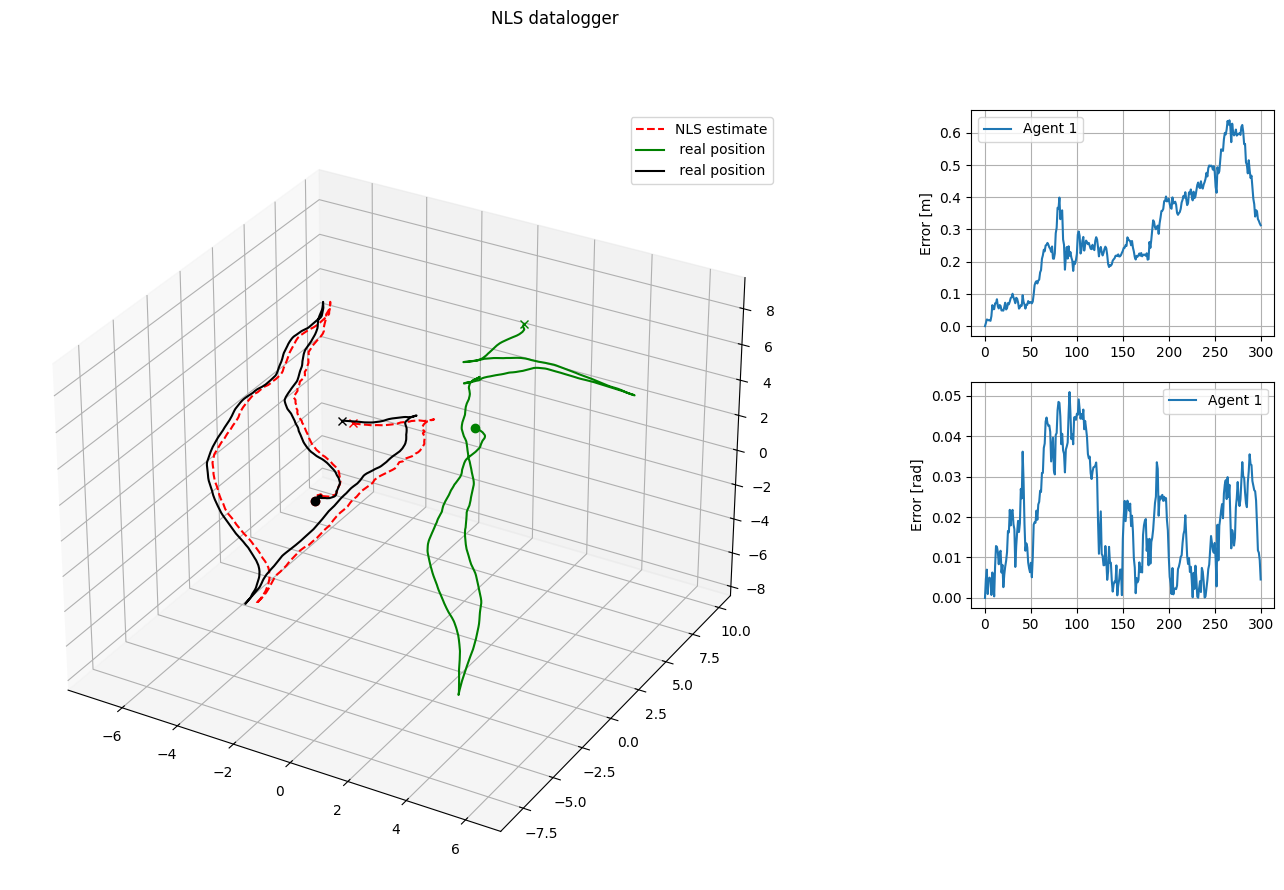

In [28]:

nls_logger.plot_graphs()
plt.show()

### QCQP
It is important to note you need a Gurboi license to run this code.
#### Setting up the QCQP

In [29]:
from importlib import reload
import Code.DataLoggers.QCQP_DataLogger as QCQPDL
reload(QCQPDL)

from Code.BaseLines.QCQP import QCQP
from Code.DataLoggers.QCQP_DataLogger import QCQP_Log

qcqp = QCQP(horizon=500,  sigma_uwb=sigma_uwb)
qcqp_log = QCQP_Log(qcqp, drone_0, drone_1)

#### Running the QCQP simulation

In [30]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps+1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor) == 0:
        qcqp.update(dx_0, dx_1, distances[i])
        qcqp_log.log(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))



#### Plotting the results

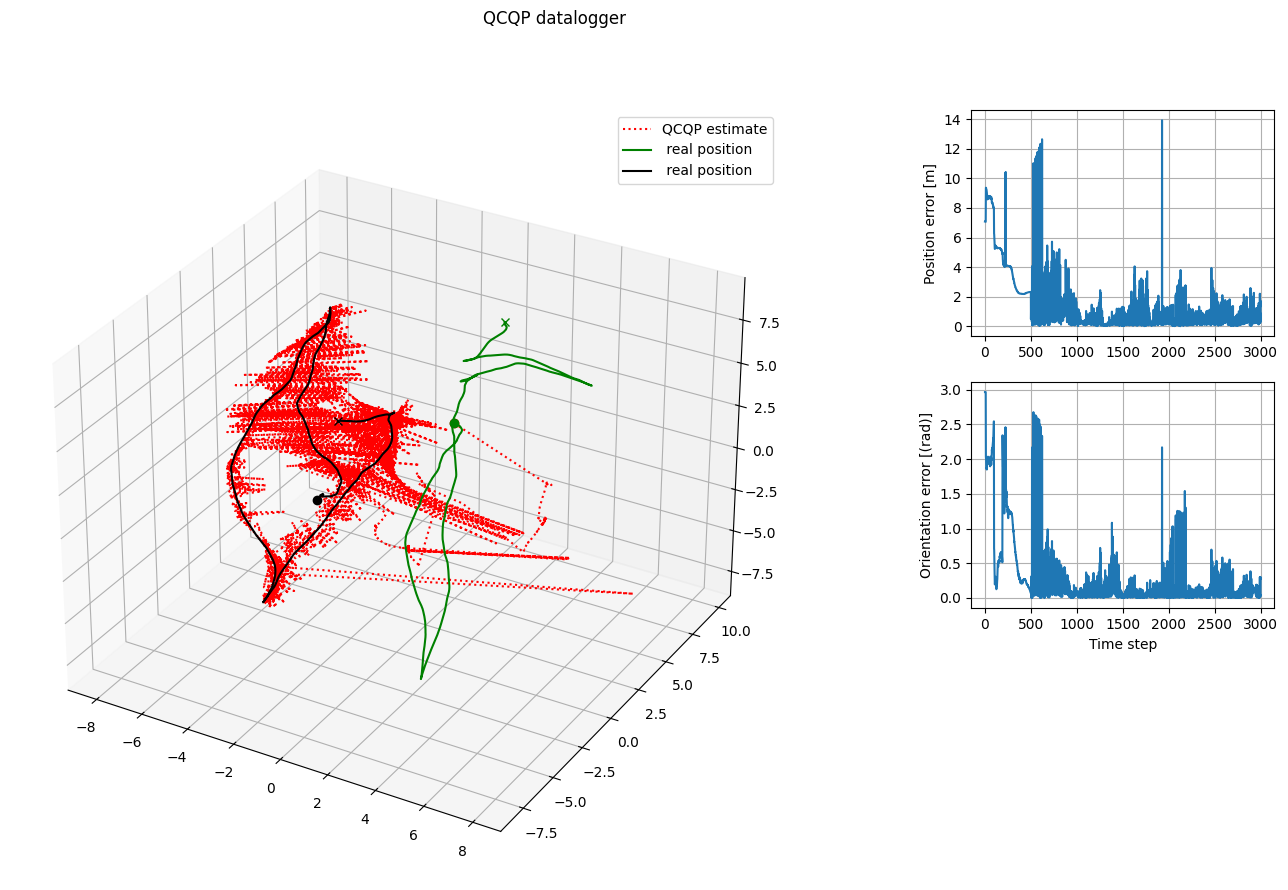

In [31]:
qcqp_log.plot_graphs()
plt.show()

### Algebraic


#### Setting up the Algebraic method

In [32]:
from importlib import reload
import Code.BaseLines.AlgebraicMethod4DoF as AM
reload(AM)

from Code.BaseLines.AlgebraicMethod4DoF import AlgebraicMethod4DoF
from Code.BaseLines.AlgebraicMethod4DoF import Algebraic4DoF_Logger

AM0 = AlgebraicMethod4DoF(distances[0], sigma_uwb=sigma_uwb, x_ha=pose_drone_0)
AM0.horizon = 100
alg_log = Algebraic4DoF_Logger(alg_solver=AM0, host=drone_0, connect=drone_1)

#### Running the Algebraic method simulation

In [33]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor) == 0:
        d = distances[i]
        AM0.get_update(d=d, dx_ha=dx_0, dx_ca=dx_1, q_ha=q_0, q_ca=q_1)

        alg_log.log(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))

#### Plotting the results

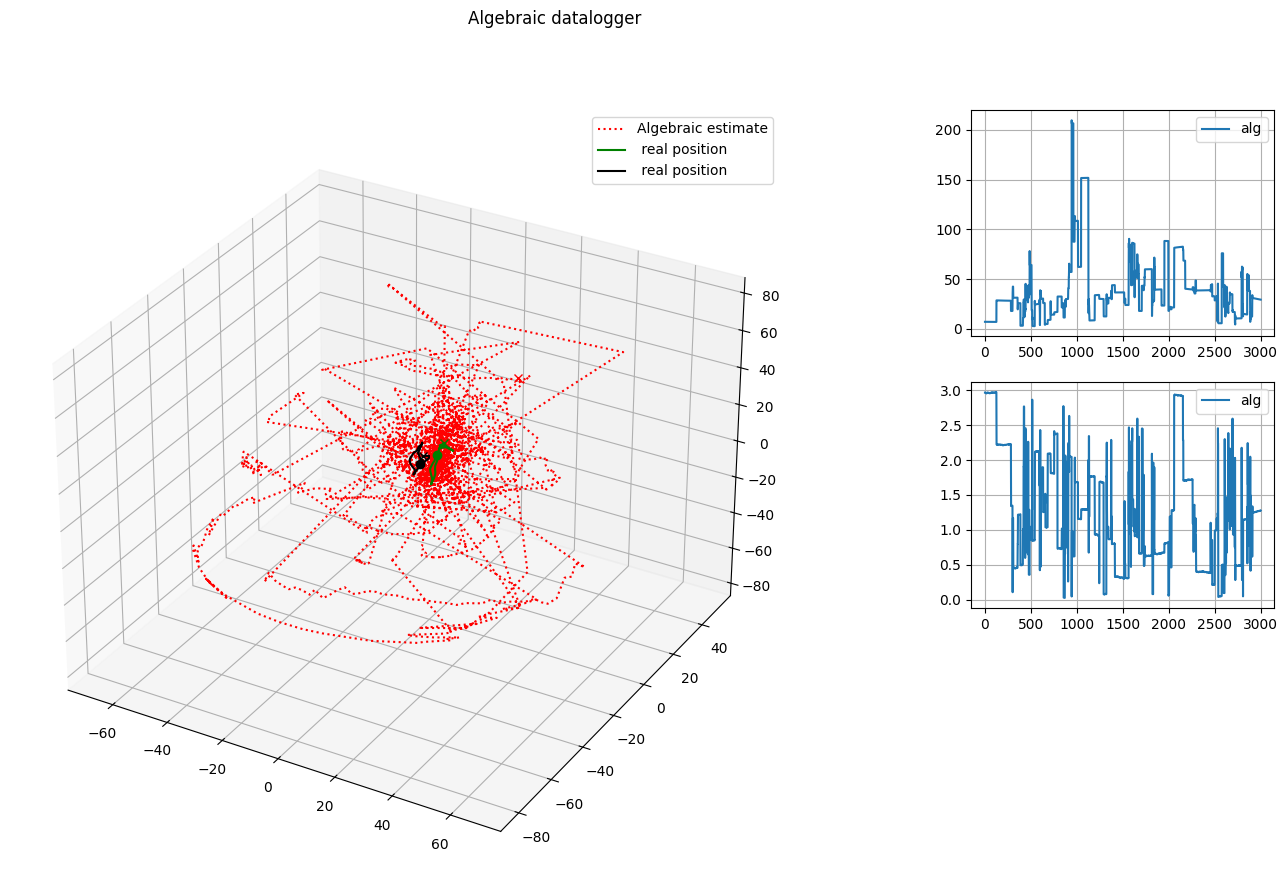

In [34]:
alg_log.plot_graphs()
plt.show()

### Running analysis

## Running in ROS environment

### ROS1 

In [ ]:
import Code 
from Code.UtilityCode.
import rospy
import numpy as np
from nav_msgs.msg import Odometry
from std_msgs.msg import Float32

class RPE_UPF:
    def __init__(self, sigma_uwb, sigma_v, sigma_w):
        # We assume that the linear velocity and rotation speed are in the odometry messages.
        self.agent0_sub = rospy.Subscriber("/agent_0/new_odom", Odometry, self.odom0_callback)
        self.agent2_sub = rospy.Subscriber("/agent_1/new_odom", Odometry, self.odom1_callback)
        # Since there is no UWB sensor in ros msgs we assume that the UWB sensor is a float32 message.
        self.distance_sub = rospy.Subscriber("/uwb_measurement", Float32, self.rpe_callback)
            
        self.sigma_uwb = sigma_uwb
        # IF their is no covariance in the message.
        self.sigma_v = sigma_v
        self.sigma_w = sigma_w
        self.q = np.eye(4)*self.sigma_v 
        self.q[-1,-1] = self.sigma_w
                        
        self.t_s0 =np.zeros(4)
        self.Dt_s0 = np.zeros(4)
        self.q_0 = np.zeros((4, 4))
        self.t0 = None
        self.Dt_s1 = np.zeros(4)
        self.q_1 = np.zeros((4, 4))
        self.t1 = None
        
        self.upf = None
        
        
    
    def odom0_callback(self, odom_msg):
        yaw = np.arctan2(2.0 * (odom_msg.pose.pose.orientation.w * odom_msg.pose.pose.orientation.z + odom_msg.pose.pose.orientation.x * odom_msg.pose.pose.orientation.y), 1.0 - 2.0 * (odom_msg.pose.pose.orientation.y * odom_msg.pose.pose.orientation.y + odom_msg.pose.pose.orientation.z * odom_msg.pose.pose.orientation.z)) 
        self.t_s0 = np.array([odom_msg.pose.pose.position.x, odom_msg.pose.pose.position.y, odom_msg.pose.pose.position.z, yaw])
    
        if self.t0 is not None:
            dt0 = (odom_msg.header.stamp.to_sec()  - self.t0)
            self.t0 = odom_msg.header.stamp.to_sec() 
            self.Dt_s0 = np.array([odom_msg.twist.twist.linear.x, odom_msg.twist.twist.linear.y, odom_msg.twist.twist.linear.z, odom_msg.twist.twist.angular.z])*dt0
            self.q_0 = self.q_0 + np.array(odom_msg.twist.coavariance)*dt0
            
   
        if self.upf is None: 
            # this should be calculation with quaternions: 
            
            self.upf = UPFConnectedAgent(id="drone_1", x_ha_0=x_drone_0, drift_correction_bool=True, resample_factor=0.1)
    
    def odom_callback(self, odom, agent):
        
        pass

    def odom1_callback(self, odom):
        
        odom.header.frame_id = "odom"
        odom.child_frame_id = "velodyne"

        self.dlo_pub.publish(odom)
        
    def rpe_callback(self, distance):
        if self.t0 is None or self.t1 is None or self.upf is None:
            return
        
        
        
        self.upf.ha.update(self.t_s0, self.q_0)
        self.upf.run_model(self.Dt_s1, distance, q_ca=self.q_1)
        self.upf.ha.reset_integration()
        
        self.Dt_s1 = np.zeros(4)
        self.q_1 = np.zeros((4, 4))
        self.Dt_s0 = np.zeros(4)
        self.q_0 = np.zeros((4, 4))    
        

if __name__ == "__main__":
    rospy.init_node('upf_rpe', anonymous=False)
    ros1_node = RPE_UPF()

### ROS2